In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
from decode_fish.imports import *
from decode_fish.funcs.file_io import *
from decode_fish.funcs.emitter_io import *
from decode_fish.funcs.utils import *
from decode_fish.funcs.dataset import *
from decode_fish.funcs.plotting import *
from decode_fish.engine.noise import estimate_noise_scale
import shutil
from decode_fish.funcs.visualization import *
from decode_fish.funcs.predict import predict

In [4]:
import os
os.environ["CUDA_VISIBLE_DEVICES"] = '0'

# Training

In [5]:
base_dir = '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/'
group = glob.glob(base_dir+'/*tiff')
print(len(group))

17


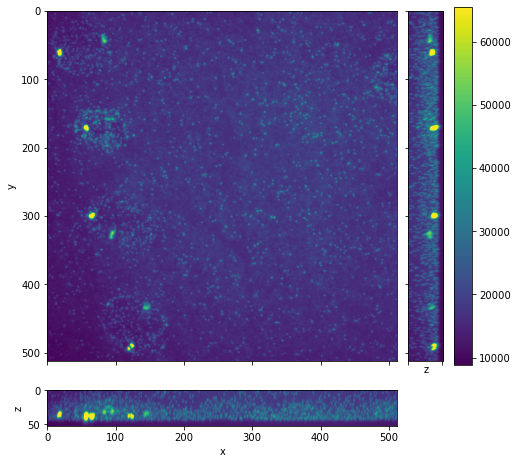

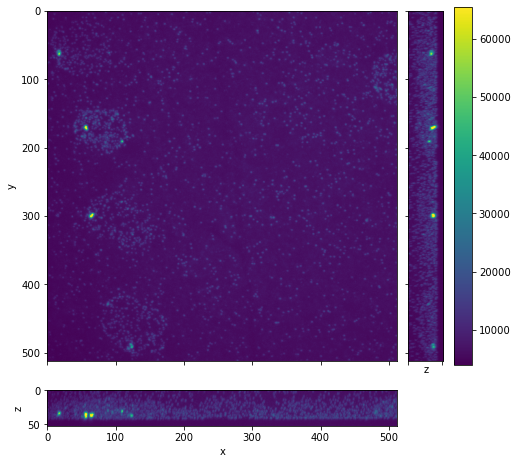

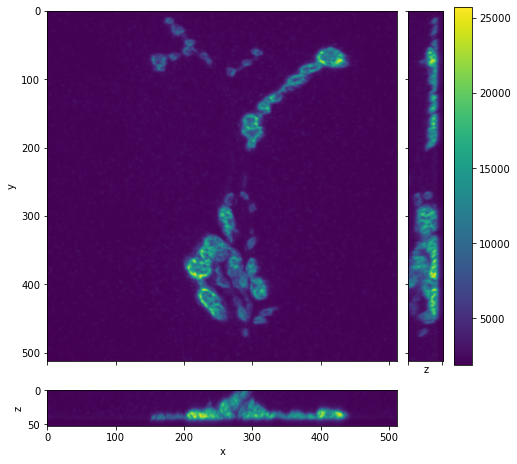

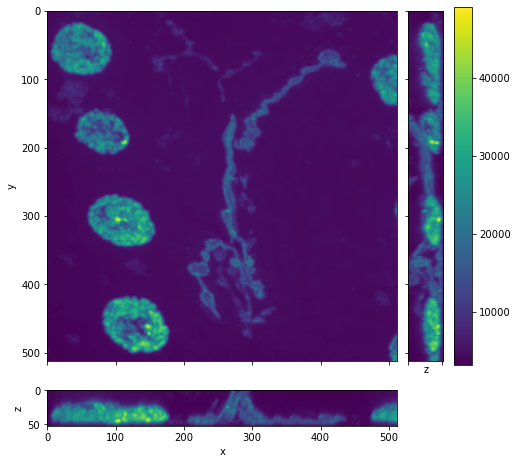

In [6]:
img = tiff_imread(sorted(group)[13])
for i in range(4):
    plot_3d_projections(img[i])

Load base config

In [64]:
cfg = OmegaConf.load('../config/train.yaml')

Make dataset specific changes

In [65]:
cfg.output.project = 'CL_dlg1'

# Path to the recording you want to train the network on. Can also use a * expression to load multiple tiffs (e.g. path/*.tif)
cfg.data_path.image_path = cfg.base_dir + 'datasets/CodFish/raw_data_for_codetection/*.tiff'

# We initialize the PSF as a Gaussian with the given radii. Should be adjusted to get a rough visual fit between recording and simulation.
cfg.data_path.psf_path = None
cfg.PSF.psf_extent_zyx = [21,21,21]
cfg.PSF.gauss_radii = [2.,1.,1.]

cfg.evaluation.img_ind = 13
cfg.evaluation.crop_sl = 's_[:,:,100:200,0:100]'
cfg.evaluation.px_size_zyx =  [100,100,100]

# Average number of foci per simulated volume. If your data does not contain any foci set this to 0.
cfg.foci.n_foci_avg = 2
# Lower and upper limit of emitters simulated per focus
cfg.foci.n_mol_range: [5,30]

cfg.prob_generator.low = 0.0002
cfg.prob_generator.high = 0.001

# Set to 'disabled' if you do not have a wandb account.
cfg.output.wandb_mode = 'online'

cfg.bg_estimation.fractal.res = [3,6,6]

cfg.run_name ='CL_dlg1_f4_ch0'
cfg.data_path.sm_fish_ch = 0
cfg.noise.theta = float(100.)
cfg.microscope.scale = 3500
cfg.bg_estimation.fractal.persistence = 0.75
cfg.bg_estimation.fractal.scale = 3500

# cfg.run_name ='CL_dlg1_f4_ch1'
# cfg.data_path.sm_fish_ch = 1
# cfg.noise.theta = float(50.)
# cfg.microscope.scale = 2000
# cfg.bg_estimation.fractal.persistence = 0.5
# cfg.bg_estimation.fractal.scale = 1000

In [66]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'CL_dlg1_f4_ch1'

We load the image and use a simple heuristic function to estimate the noise scale. Here we use the 99% lowest intensity values
to exlude the majority of the signal. Set the percentile value to obtain a range like below. If it is to high (e.g. 99.9 in this example) you will see a long tail with high intensities, if it is to low, e.g. 95 you will get something that looks like a truncated Gaussian.

99.22808905534023


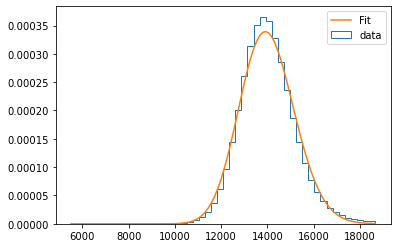

In [58]:
img = load_tiff_image(glob.glob(cfg.data_path.image_path)[12])[cfg.data_path.sm_fish_ch][None]
bg_est = hydra.utils.instantiate(cfg.bg_estimation.smoothing)(img)
theta = estimate_noise_scale(img, bg_est, percentile=99)
print(theta)

Here we plot maximum intensity projections of the whole volume and the sub volume given by evaluation.crop_sl.  
The localizations for this sub volume are tracked during training to evaluate progress. You should chose an interesting (e.g. dense) region.

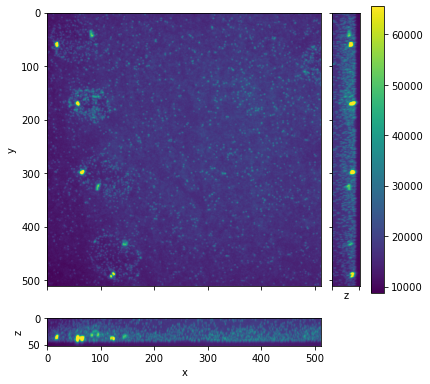

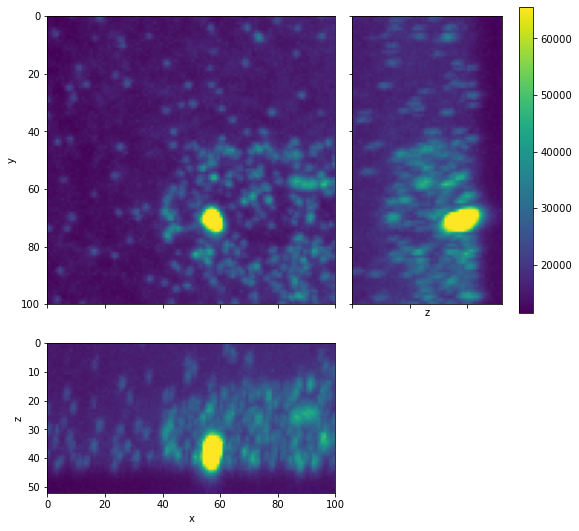

In [50]:
eval_img = load_tiff_image(sorted(glob.glob(cfg.data_path.image_path))[cfg.evaluation.img_ind])[cfg.data_path.sm_fish_ch][None]
_ = plot_3d_projections(eval_img, size=5, proj_func=np.max)
sl = eval(cfg.evaluation.crop_sl,{'__builtins__': None},{'s_': np.s_})
_ = plot_3d_projections(eval_img[sl[:]], size=5)

Create the dataloader which samples random subsets from the recorded volumes and generates simulated data that we use for training.  
For visualization purposes it is often better to not sample foci as they distort the colorscale.

In [59]:
n_foci = cfg.foci.n_foci_avg
cfg.foci.n_foci_avg = 0
img_3d, decode_dl = get_dataloader(cfg)
psf, noise, micro = load_psf_noise_micro(cfg)
cfg.foci.n_foci_avg = n_foci

Crop size larger than volume in at least one dimension. Crop size changed to (31, 48, 48)
17 volumes


This function allows you to visually compare the recorded data and the simulations generated with the given config.  
For each sample we plot a slice from the input volume and from a simulated training volume as well as the estimated background.  
In the second row we compare maximum intensity projections.  

Adjust the microscope.scale and PSF.gauss_radii until you achieve a rough match in intensities and the PSF shape.  
You don't have to get this exactly right as these values get automatically fine tuned during training.
It is totally fine if average density of emitters in the simulations is higher than in the recordings.

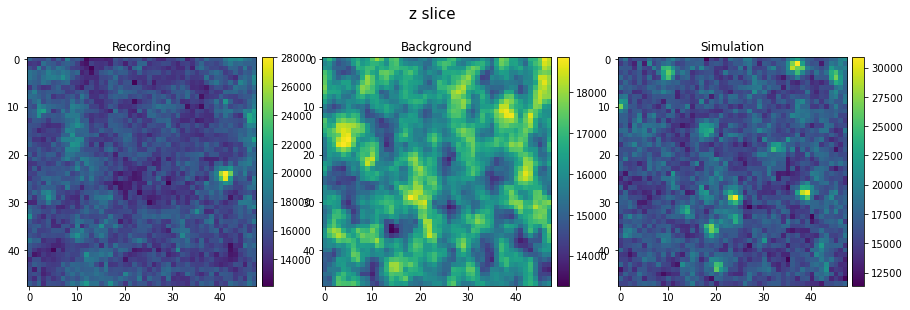

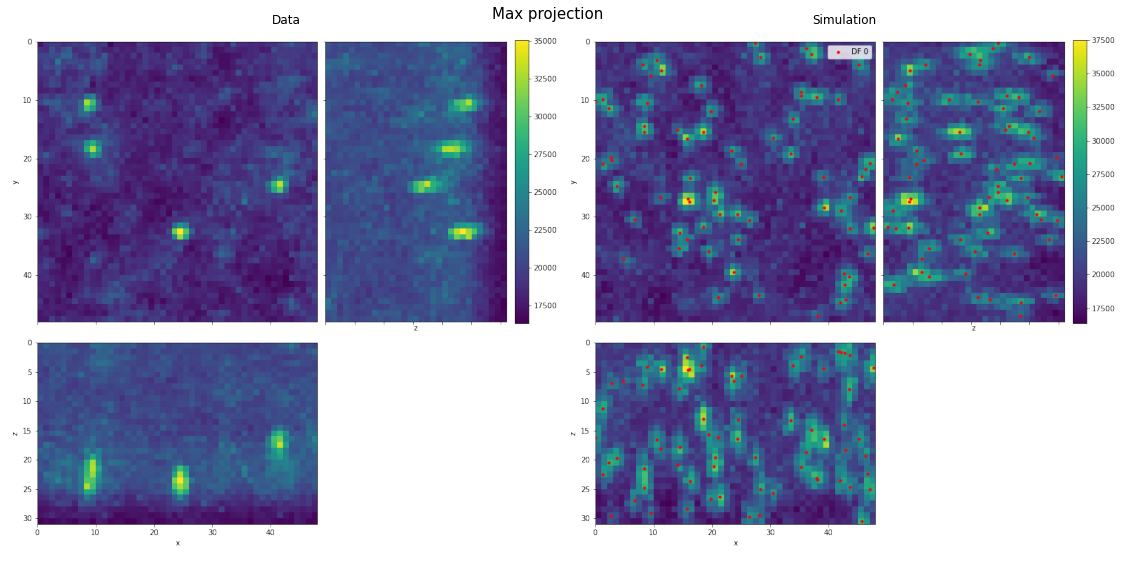

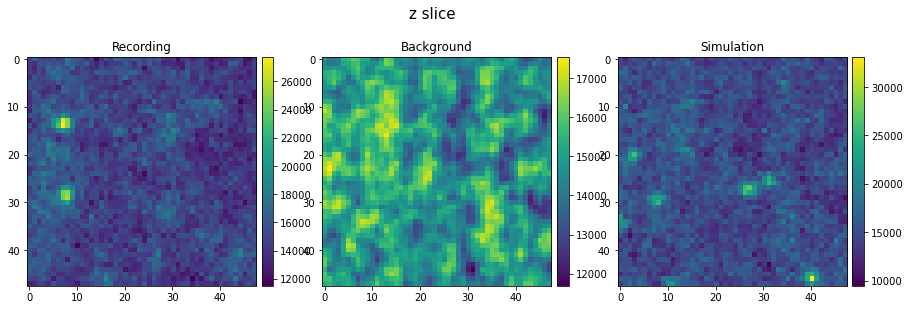

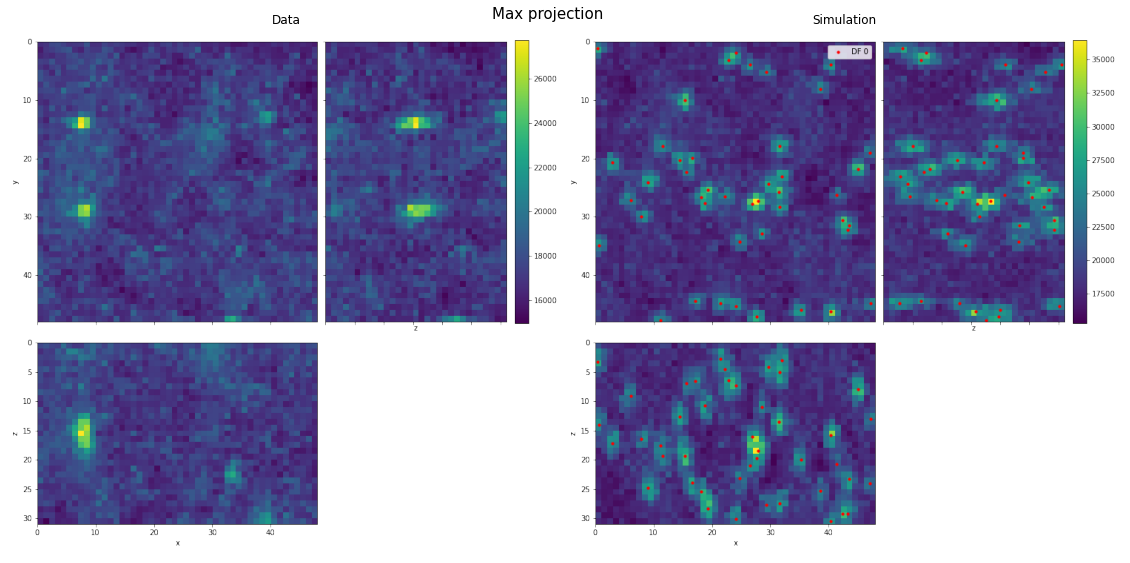

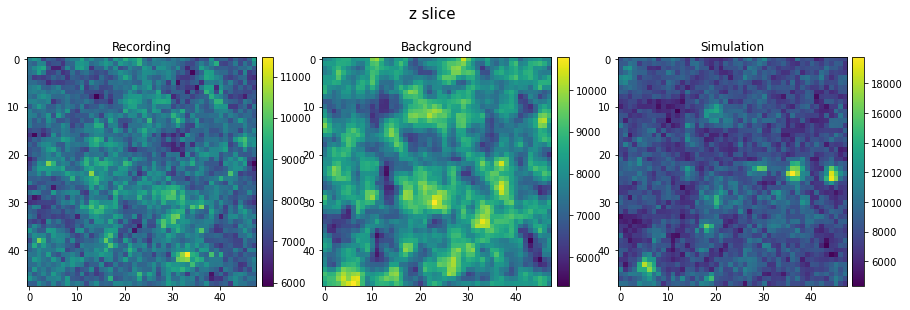

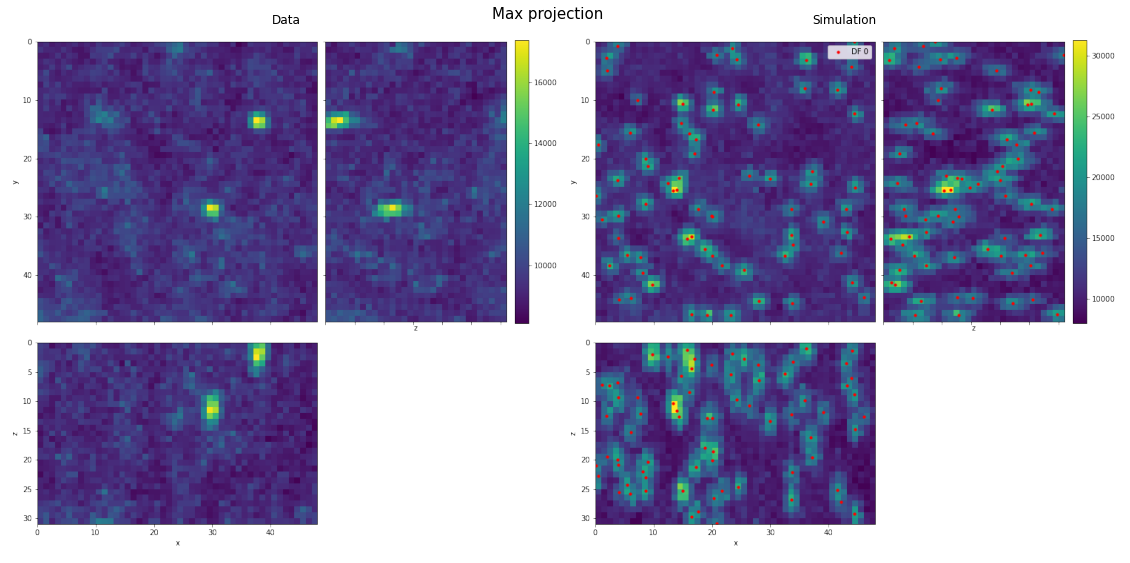

In [60]:
get_simulation_statistics(decode_dl, micro, **cfg.intensity_dist, int_threshold=10, samples=3)

Store the config as an experiment

In [14]:
OmegaConf.save(cfg, f'../config/experiment/{cfg.run_name}.yaml')
cfg.run_name

'CL_dlg1_f2_ch0'

The config file is all you need to train your model. There is a couple of options.  
* You can load the config in the nbs/13_train.ipynb notebook and run all cells. This will continuously produce plots that let you track the training progress.  
* The recommended method is to execute the exeriment in your terminal: "python decode_fish/train.py +experiment=msp300_1"  If you enabled wandb tracking you will get a link for this run.
* You change parameters of your parameters in the command line. For example if you want to run training for more iterations you could execute:  
"python decode_fish/train.py +experiment=msp300_1 training.num_iters=50000 run_name=long_run"


Command to train a model on the gpu cluster

In [67]:
home_dir = os.getenv("HOME")
f'bsub -gpu "num=1" -q gpu_any -o {home_dir}/logs/ofish.log -e {home_dir}/logs/efish.log {home_dir}/anaconda3/envs/decode_fish_dev/bin/python {home_dir}/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment={cfg.run_name}'

'bsub -gpu "num=1" -q gpu_any -o /groups/turaga/home/speisera/logs/ofish.log -e /groups/turaga/home/speisera/logs/efish.log /groups/turaga/home/speisera/anaconda3/envs/decode_fish_dev/bin/python /groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/decode_fish/train.py +experiment=CL_dlg1_f4_ch1'

# Evaluation

In [79]:
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/CL_dlg1/nb_run/CL_dlg1_f1_ch1/train.yaml')
cfg = OmegaConf.load(f'/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/CL_dlg1/sweep_1/lr:0.00025xtheta:150.0xscale:3500.0/train.yaml')

In [80]:
# Load the model, post processing, imgages, dataloader
model, post_proc, micro, img_3d, decode_dl = load_all(cfg)
psf_init = get_gaussian_psf(cfg.PSF.psf_extent_zyx,cfg.PSF.gauss_radii)
psf_init = cpu(psf_init.psf_volume[0])
psf_vol = cpu(micro.psf.psf_volume[0])

Crop size larger than volume in at least one dimension. Crop size changed to (31, 48, 48)
17 volumes


Plot mean projections of the PSF before and after optimizing it during training

(tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>), tensor(10.0000, device='cuda:0', grad_fn=<DivBackward0>))


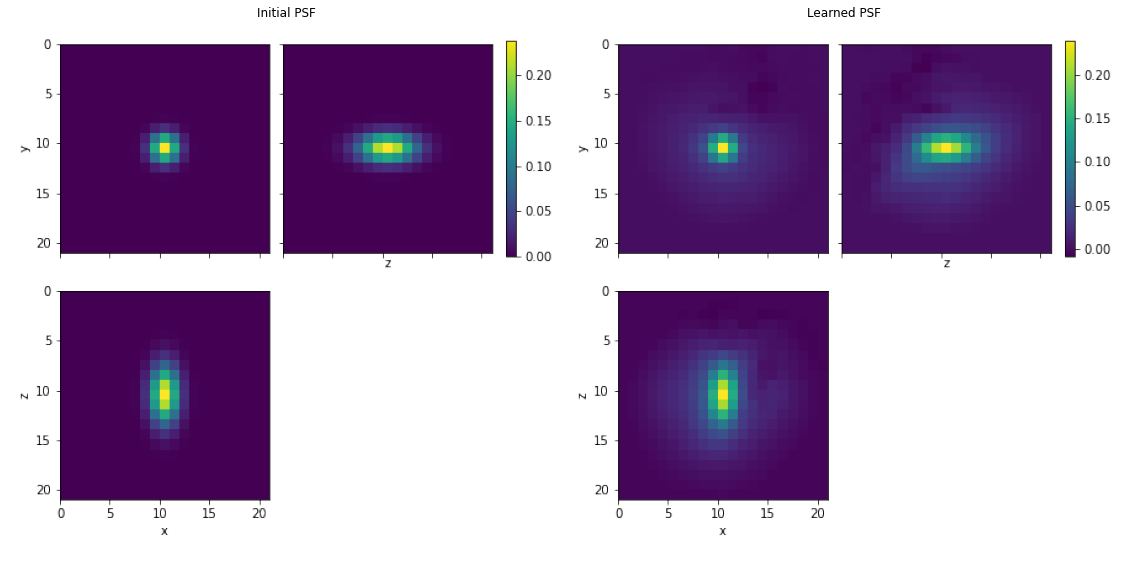

In [81]:
print(micro.psf.get_com())
fig1,_ =plot_3d_projections(psf_init, proj_func=np.mean, size=3, display=False)
fig2,_ =plot_3d_projections(psf_vol, proj_func=np.mean, size=3, display=False)
_ = combine_figures([fig1,fig2],['Initial PSF','Learned PSF'], nrows=1, ncols=2, figsize=(20,10))

Sample random sub volumes and overlay them with predictions,  also shows the residuals between the input volume and the reconstruction from applying the microscope and PSF model to those predictions. Sometimes it looks like the network if missing obvious molecules. Often times this is because they are at the very edge of the volume. In that case they will be localized once you process the whole volume.

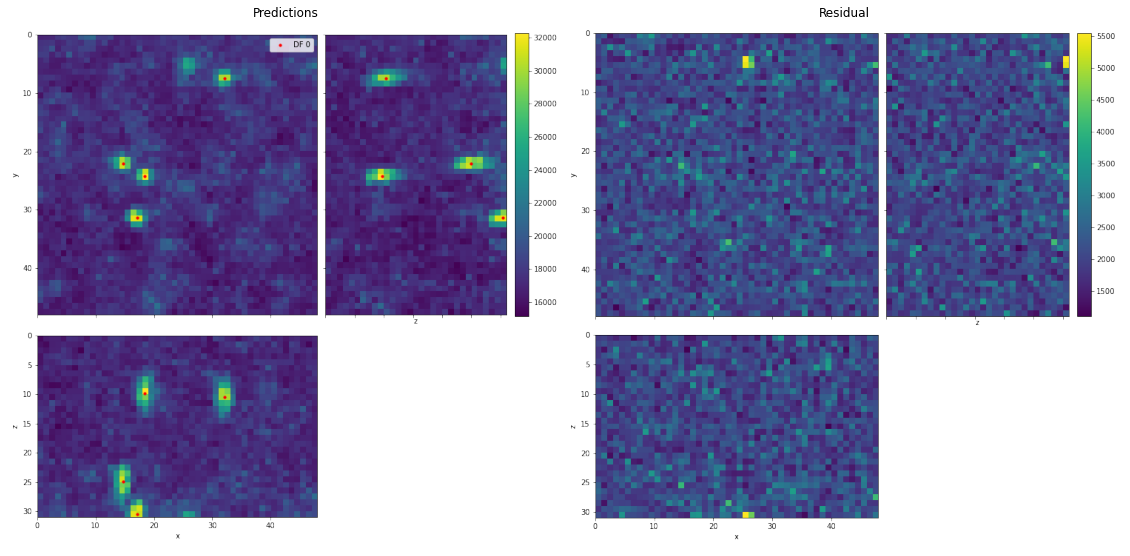

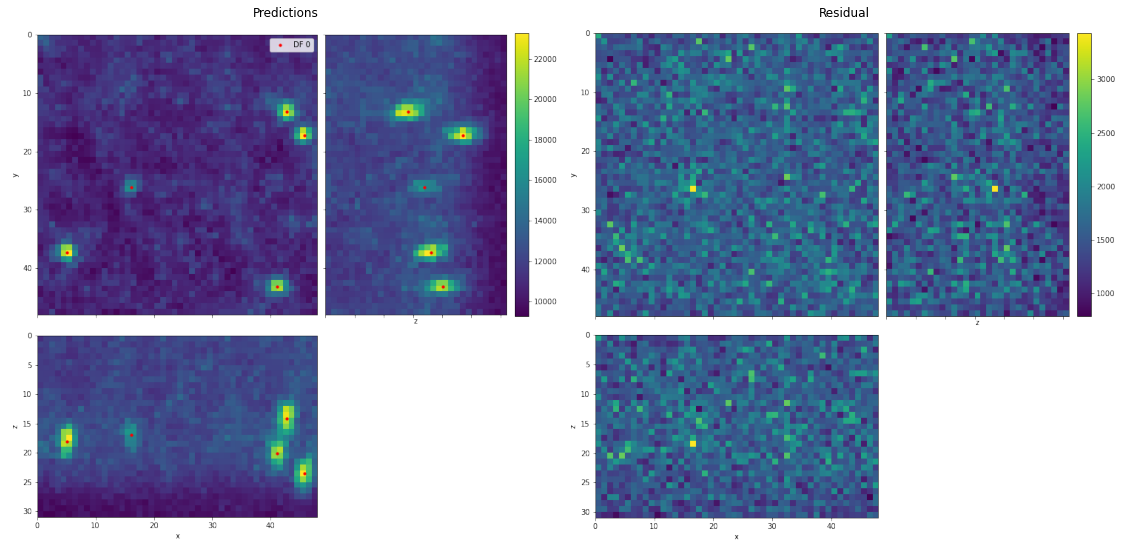

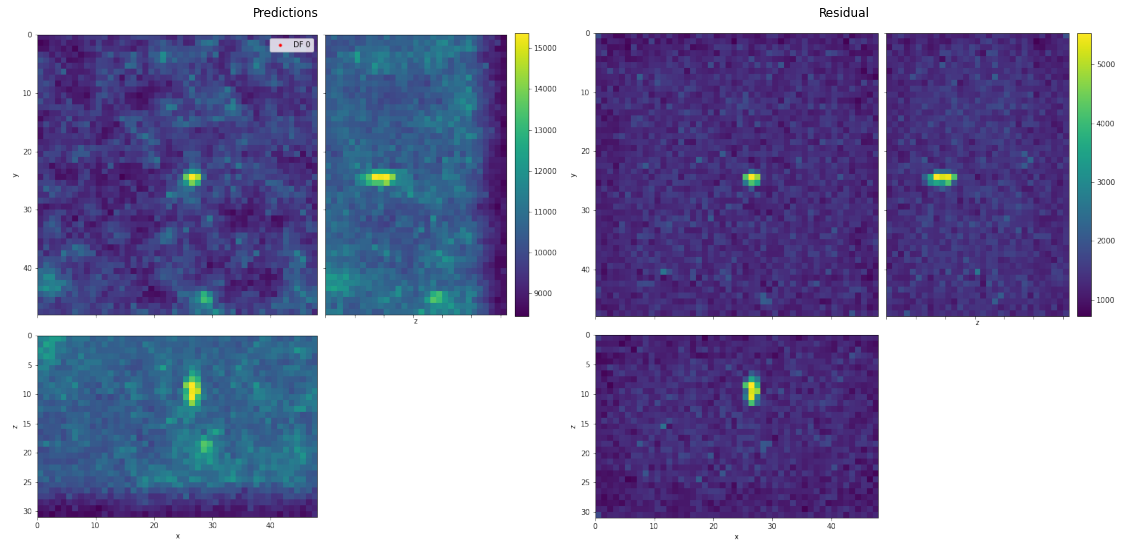

In [82]:
eval_random_crop(decode_dl, model, post_proc, micro, samples=3)

If you are happy with the results you can run the network on whole volumes to get predictions. Be aware that a model will only produce good results on different recordings if the conditions with regards to PSF and intensity are similar as those used during training.

In [83]:
# Chose paths of the tif files you wan't to process
image_paths = sorted(glob.glob(str(Path(cfg.data_path.image_path))))
image_paths

['/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s3l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s3r.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s4l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s4r.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s5l.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/raw_data_for_codetection/20170326_dlgYFP_YFPATTO647N_dlg570_p1s5r.ome.tiff',
 '/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deeps

In order to run our network on arbitrarily large volumes we use a sliding window approach.  
Be aware that all leading dimensions (i.e. different channels) get flattened and treated as seperate 'frames'  
**Warning: This method might show inconsistent behavior depending on the window size and sometimes outputs extremely large numbers of localizations. Needs further testing**

In [84]:
from monai.inferers import sliding_window_inference
def predict(model, post_proc, image_paths, sm_fish_ch, window_size=[None,128,128], device='cuda'):
    pred_df = DF()
    with torch.no_grad():
        for p in tqdm(image_paths):
            print(p.split('/')[-1])
            img = load_tiff_image(p)[sm_fish_ch]
            z, y, x = img.shape[-3:]
            img = img.reshape(-1,z,y,x)
            for i in range(len(img)):
                print(img[i][None,None].shape)
                output = sliding_window_inference(img[i][None,None], window_size, 1, model.to(device), overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                # output = model.cpu()(img[i][None,None])
                output = model.tensor_to_dict(output)
                p_si = sliding_window_inference(output['logits'], window_size, 1, post_proc, overlap=0.2, sw_device=device, device='cpu', mode='gaussian')
                i_df = post_proc.get_df(output, p_si)
                print('N. emitters: ', len(i_df))
                pred_df = append_emitter_df(pred_df, i_df)
                free_mem()
        return pred_df

In [85]:
pred_df = predict(model, post_proc, image_paths, cfg.data_path.sm_fish_ch, window_size=[None, 128, 128], device='cuda')

  0%|                                                                        | 0/17 [00:00<?, ?it/s]

20170326_dlgYFP_YFPATTO647N_dlg570_p1s3l.ome.tiff
torch.Size([1, 1, 38, 512, 512])


  6%|███▊                                                            | 1/17 [00:03<00:54,  3.38s/it]

N. emitters:  655
20170326_dlgYFP_YFPATTO647N_dlg570_p1s3r.ome.tiff
torch.Size([1, 1, 40, 512, 512])


 12%|███████▌                                                        | 2/17 [00:06<00:52,  3.50s/it]

N. emitters:  1216
20170326_dlgYFP_YFPATTO647N_dlg570_p1s4l.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 18%|███████████▎                                                    | 3/17 [00:12<00:58,  4.21s/it]

N. emitters:  981
20170326_dlgYFP_YFPATTO647N_dlg570_p1s4r.ome.tiff
torch.Size([1, 1, 58, 512, 512])


 24%|███████████████                                                 | 4/17 [00:17<01:01,  4.75s/it]

N. emitters:  1057
20170326_dlgYFP_YFPATTO647N_dlg570_p1s5l.ome.tiff
torch.Size([1, 1, 111, 512, 512])


 29%|██████████████████▊                                             | 5/17 [00:28<01:25,  7.14s/it]

N. emitters:  1747
20170326_dlgYFP_YFPATTO647N_dlg570_p1s5r.ome.tiff
torch.Size([1, 1, 40, 512, 512])


 35%|██████████████████████▌                                         | 6/17 [00:32<01:06,  6.00s/it]

N. emitters:  1812
20170326_dlgYFP_YFPATTO647N_dlg570_p2s3l.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 41%|██████████████████████████▎                                     | 7/17 [00:37<00:57,  5.70s/it]

N. emitters:  434
20170326_dlgYFP_YFPATTO647N_dlg570_p2s3r.ome.tiff
torch.Size([1, 1, 35, 512, 512])


 47%|██████████████████████████████                                  | 8/17 [00:40<00:43,  4.88s/it]

N. emitters:  284
20170326_dlgYFP_YFPATTO647N_dlg570_p2s4r.ome.tiff
torch.Size([1, 1, 66, 512, 512])


 53%|█████████████████████████████████▉                              | 9/17 [00:47<00:42,  5.37s/it]

N. emitters:  300
20170326_dlgYFP_YFPATTO647N_dlg570_p2s5l.ome.tiff
torch.Size([1, 1, 49, 512, 512])


 59%|█████████████████████████████████████                          | 10/17 [00:51<00:35,  5.08s/it]

N. emitters:  452
20170326_dlgYFP_YFPATTO647N_dlg570_p2s5r.ome.tiff
torch.Size([1, 1, 31, 512, 512])


 65%|████████████████████████████████████████▊                      | 11/17 [00:54<00:26,  4.38s/it]

N. emitters:  358
20170326_dlgYFP_YFPATTO647N_dlg570_p3s3l.ome.tiff
torch.Size([1, 1, 48, 512, 512])


 71%|████████████████████████████████████████████▍                  | 12/17 [00:59<00:22,  4.44s/it]

N. emitters:  4122
20170326_dlgYFP_YFPATTO647N_dlg570_p3s3r.ome.tiff
torch.Size([1, 1, 53, 512, 512])


 76%|████████████████████████████████████████████████▏              | 13/17 [01:04<00:18,  4.68s/it]

N. emitters:  3771
20170326_dlgYFP_YFPATTO647N_dlg570_p3s4l.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 82%|███████████████████████████████████████████████████▉           | 14/17 [01:09<00:14,  4.81s/it]

N. emitters:  3224
20170326_dlgYFP_YFPATTO647N_dlg570_p3s4r.ome.tiff
torch.Size([1, 1, 52, 512, 512])


 88%|███████████████████████████████████████████████████████▌       | 15/17 [01:14<00:09,  4.90s/it]

N. emitters:  2502
20170326_dlgYFP_YFPATTO647N_dlg570_p3s5l.ome.tiff
torch.Size([1, 1, 66, 512, 512])


 94%|███████████████████████████████████████████████████████████▎   | 16/17 [01:21<00:05,  5.52s/it]

N. emitters:  3483
20170326_dlgYFP_YFPATTO647N_dlg570_p3s5r.ome.tiff
torch.Size([1, 1, 42, 512, 512])


100%|███████████████████████████████████████████████████████████████| 17/17 [01:25<00:00,  5.02s/it]

N. emitters:  1919


In [86]:
pred_0 = pred_df

(array([1.9360e+03, 1.1773e+04, 8.4700e+03, 3.6950e+03, 1.6590e+03,
        6.1700e+02, 1.3600e+02, 2.6000e+01, 3.0000e+00, 2.0000e+00]),
 array([0.30541247, 0.37157112, 0.4377298 , 0.5038885 , 0.57004714,
        0.6362058 , 0.70236444, 0.7685231 , 0.8346818 , 0.90084046,
        0.9669991 ], dtype=float32),
 <BarContainer object of 10 artists>)

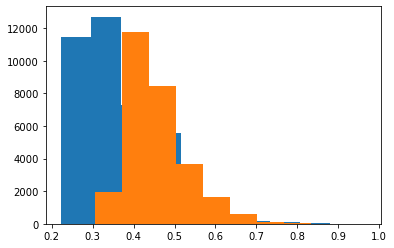

In [115]:
plt.hist(pred_1['comb_sig'])
plt.hist(pred_0['comb_sig'])

In [118]:
pred_1_corr = shift_df(pred_1, [63.55,-26.54,146.37])
pred_1_corr = pred_1_corr[pred_1_corr['comb_sig']<0.4]

In [120]:
len(pred_1_corr)

28317

In [121]:
for i in range(15):
    pred_0_sub = pred_0[pred_0['frame_idx']==i]
    pred_1_sub = pred_1_corr[pred_1_corr['frame_idx']==i]
    perf_df, matches, shift = matching(pred_0_sub, pred_1_sub, print_res=True)

  0%|                                                                         | 0/2 [00:00<?, ?it/s]

Recall: 0.838
Precision: 0.582
Jaccard: 52.286
RMSE_vol: 75.884
Eff_3d: 39.039
FN: 106.0 FP: 395.0
Shift: -3.81,-1.62,10.27


  0%|                                                                         | 0/3 [00:00<?, ?it/s]

Recall: 0.738
Precision: 0.797
Jaccard: 62.076
RMSE_vol: 69.597
Eff_3d: 48.530
FN: 319.0 FP: 229.0
Shift: -4.13,1.29,7.83


  0%|                                                                         | 0/4 [00:00<?, ?it/s]

Recall: 0.846
Precision: 0.705
Jaccard: 62.500
RMSE_vol: 72.914
Eff_3d: 47.699
FN: 151.0 FP: 347.0
Shift: -3.02,-5.61,14.35


  0%|                                                                         | 0/5 [00:00<?, ?it/s]

Recall: 0.759
Precision: 0.750
Jaccard: 60.574
RMSE_vol: 76.674
Eff_3d: 45.008
FN: 255.0 FP: 267.0
Shift: 2.74,2.97,31.71


  0%|                                                                         | 0/6 [00:00<?, ?it/s]

Recall: 0.829
Precision: 0.767
Jaccard: 66.255
RMSE_vol: 101.821
Eff_3d: 38.922
FN: 298.0 FP: 440.0
Shift: 9.68,-43.50,53.59


  0%|                                                                         | 0/7 [00:00<?, ?it/s]

Recall: 0.676
Precision: 0.832
Jaccard: 59.466
RMSE_vol: 81.711
Eff_3d: 42.449
FN: 587.0 FP: 248.0
Shift: 7.08,6.98,37.64


  0%|                                                                         | 0/8 [00:00<?, ?it/s]

Recall: 0.650
Precision: 0.571
Jaccard: 43.653
RMSE_vol: 51.518
Eff_3d: 38.044
FN: 152.0 FP: 212.0
Shift: 0.96,4.87,21.57


  0%|                                                                         | 0/9 [00:00<?, ?it/s]

Recall: 0.683
Precision: 0.602
Jaccard: 47.087
RMSE_vol: 55.772
Eff_3d: 40.189
FN: 90.0 FP: 128.0
Shift: -2.99,-1.89,34.32


  0%|                                                                        | 0/10 [00:00<?, ?it/s]

Recall: 0.667
Precision: 0.602
Jaccard: 46.296
RMSE_vol: 65.568
Eff_3d: 37.080
FN: 100.0 FP: 132.0
Shift: 11.78,4.05,20.74


  0%|                                                                        | 0/11 [00:00<?, ?it/s]

Recall: 0.573
Precision: 0.520
Jaccard: 37.482
RMSE_vol: 66.600
Eff_3d: 29.166
FN: 193.0 FP: 239.0
Shift: 4.18,1.75,32.42


  0%|                                                                        | 0/12 [00:00<?, ?it/s]

Recall: 0.511
Precision: 0.588
Jaccard: 37.654
RMSE_vol: 76.125
Eff_3d: 26.954
FN: 175.0 FP: 128.0
Shift: -3.30,3.80,22.92


 92%|█████████████████████████████████████████████████████████▊     | 11/12 [00:34<00:03,  3.17s/it]


KeyboardInterrupt: 

In [122]:
from decode_fish.funcs.evaluation import matching
perf_df, matches, shift = matching(pred_0, pred_1_corr, print_res=True)

100%|███████████████████████████████████████████████████████████████| 17/17 [05:02<00:00, 17.80s/it]

Recall: 0.782
Precision: 0.825
Jaccard: 67.102
RMSE_vol: 75.787
Eff_3d: 49.818
FN: 6168.0 FP: 4691.0
Shift: 2.33,-2.89,9.87


In [91]:
from decode_fish.funcs.evaluation import matching
perf_df, matches, shift = matching(pred_0, pred_1, print_res=True)

100%|███████████████████████████████████████████████████████████████| 17/17 [07:44<00:00, 27.34s/it]

Recall: 0.871
Precision: 0.641
Jaccard: 58.529
RMSE_vol: 188.230
Eff_3d: -2.847
FN: 3653.0 FP: 13823.0
Shift: 63.55,-26.54,146.37


In [ ]:
perf_df, matches, _ = matching(pred_0, pred_1, print_res=True)

Alternatively you can run the prediction on the CPU which is a bit slower

In [269]:
# with torch.no_grad():
#     model.cpu()
#     res = model.tensor_to_dict(model(img_3d[0][None,None]))
#     pred_df = post_proc.get_df(res)
#     free_mem()

The results provided as panda DataFrames which allow for easy indexing and saving/loading.

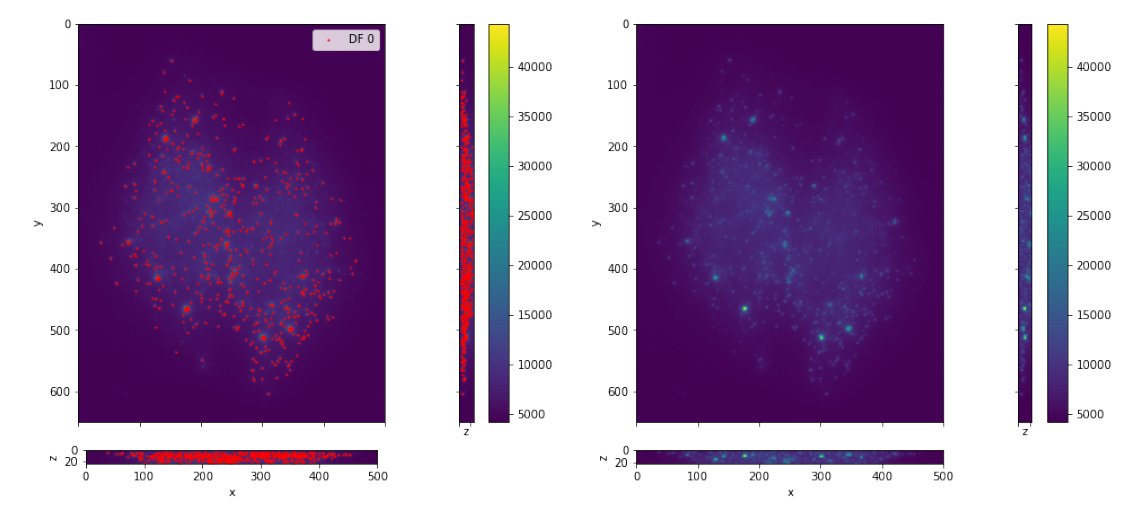

In [237]:
ind = 0
img = load_tiff_image(image_paths[ind])
preds = pred_df[pred_df['frame_idx'] == ind]
preds_px = nm_to_px(preds, px_size_zyx=cfg.evaluation.px_size_zyx)
fig1, axes = plot_3d_projections(img, display=False)
scat_3d_projections(axes, preds_px, s_fac=0.1)
fig2, axes = plot_3d_projections(img, display=False)
_ = combine_figures([fig1,fig2],[], figsize=(20,10))

In [248]:
# Save as csv
pred_df.to_csv('../data/results/BG_exmp_predictions.csv', index=False)
# Load from csv
pred_df = pd.read_csv('../data/results/BG_exmp_predictions.csv')

You can also perform the prediction with the predict.py script. Just provide the model path, the image path string, and the name for the output file.

In [13]:
# !python decode_fish/predict.py out_file='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/decode_fish/msp300_predictions.csv' \
# model_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm//models/fishcod/msp300_smFISH/nb_run/msp300_1/model.pkl' \
# image_path='/groups/turaga/home/speisera/Mackebox/Artur/WorkDB/deepstorm/datasets/CodFish/smFISH_data_Titlow/msp300*.tif'

In [ ]:
# pred_df = pd.read_csv('msp300_predictions.csv')

This package does not provide any advanced visualization tools. 
A good outside option is napari (https://napari.org/)

To view the results in napari we store just the pixel coordinates as a numpy array:

In [62]:
preds_3 = pred_df[pred_df['frame_idx'] == 2]
zyx_arr = nm_to_px(preds_3[['z','y','x']], cfg.evaluation.px_size_zyx).values
np.save('example/msp300_zyx',zyx_arr)

FileNotFoundError: [Errno 2] No such file or directory: 'example/msp300_zyx.npy'

Load the volume into napari and execute the following commands in napari to add a point layer with the predictions:  

        p_zyx = np.load('example/msp300_zyx.npy')
        points_layer = viewer.add_points(p_zyx, size=2, face_color='green', n_dimensional=True)